In [51]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import einops as ein
import pickle
import os

## Skeleton joints
## https://www.webpages.uidaho.edu/ui-prmd/

#% 1 Waist (absolute position)
#% 2 Spine (relative to waist)
#% 3 Chest (...)
#% 4 Neck
#% 5 Head
#% 6 Head tip
#% 7 Left collar
#% 8 Left upper arm 
#% 9 Left forearm
#% 10 Left hand
#% 11 Right collar
#% 12 Right upper arm 
#% 13 Right forearm
#% 14 Right hand
#% 15 Left upper leg 
#% 16 Left lower leg 
#% 17 Left foot 
#% 18 Left leg toes
#% 19 Right upper leg 
#% 20 Right lower leg 
#% 21 Right foot
#% 22 Right leg toes

correct_exercises_folder = '../data/raw/UI-PRMD/Movements/Kinect/Positions/'
incorrect_exercises_folder = '../data/raw/UI-PRMD/Incorrect Movements/Kinect/Positions/'

In [2]:
# Load single file positions
def parse_file(path):
    df = pd.read_csv(path, delim_whitespace=True, header=None)
    frames = df.shape[0]
    data = np.reshape(df.to_numpy(), (frames, 22, 3)) # Reshape into (L, J, F)
    return data

In [3]:
# Plot sample
def plot_joint_movement(data, joint=0):
    plt.plot(data[:, joint, 0], label=f'joint{joint}-x')
    plt.plot(data[:, joint, 1], label=f'joint{joint}-y')
    plt.plot(data[:, joint, 2], label=f'joint{joint}-z')

    plt.legend()
    plt.show()

In [40]:
def plot_joints(data, coord):
    for j in range(data.shape[1]):
        plt.plot(data[:, j, coord], label=f'joint{j}')
    plt.legend()
    plt.show()

In [4]:
def load_dataset(path):
    result = {}
    for f in os.scandir(path):
        if f.name.endswith('.txt'):
            tokens = f.name.split('_')
            movement = int(tokens[0][1:])
            subject = int(tokens[1][1:])#
    
            if movement not in result:
                result[movement] = {}

            data = parse_file(f.path)
            result[movement][subject] = data
            
    return result

In [5]:
def stack_movements_subjects_data(data, max_frames=1400):
    movements = []
    for movement in data:
        subjects = list(data[movement].values())
        for i in range(len(subjects)): # Pad frames for short samples
            frames = subjects[i].shape[0]
            subjects[i] = np.pad(
                subjects[i], 
                pad_width=((0, max_frames-frames), (0, 0), (0, 0)), 
                mode='mean'
            )
        
        movements.append(np.stack(subjects))
    return np.stack(movements)

In [6]:
def save_data_object(data, filename):
    filepath = os.path.join('../data/processed/', filename)
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)

In [47]:
correct_data = load_dataset(correct_exercises_folder)
correct_padded_data = stack_movements_subjects_data(correct_data)
incorrect_data = load_dataset(incorrect_exercises_folder)
incorrect_padded_data = stack_movements_subjects_data(incorrect_data)

In [10]:
output = {
    'correct': correct_data,
    'incorrect': incorrect_data
}
save_data_object(output, 'uiprmd.pkl')

In [92]:
# Complete dataset with all target, classes, exercises and subjects
complete_padded_data = np.stack([correct_padded_data, incorrect_padded_data])
save_data_object(complete_padded_data, 'uiprmd.pkl')
print(complete_padded_data.shape)

(2, 10, 10, 1400, 22, 3)


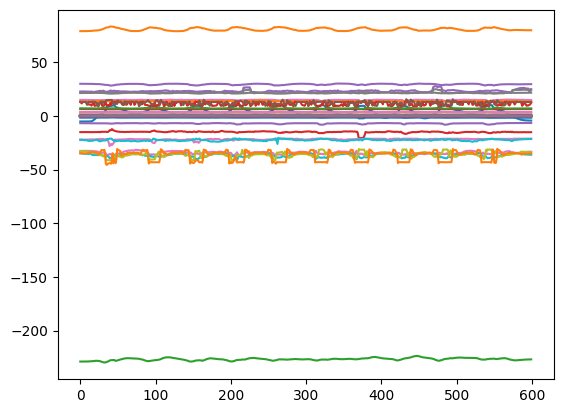

In [95]:
tmp = ein.rearrange(complete_padded_data, "C M S L J F -> C M S L (J F)")
plt.plot(tmp[0, 0, 0, :600, :])
plt.show()

(2, 10, 1400, 22, 3)
(21, 28000, 3)


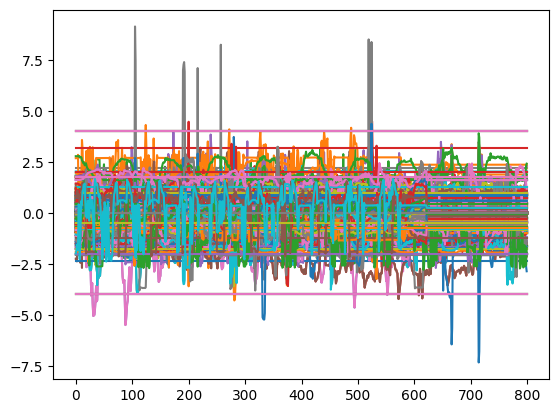

In [111]:
# Standardize all data in exercise 1, each joint is indipendent

exercise = np.copy(complete_padded_data[:, 0, ...])
print(exercise.shape)

# Removes weist, it is always at 0,0,0
exercise = np.delete(exercise, 0, axis=3)

C, S, L, J, F = exercise.shape
exercise = ein.rearrange(exercise, "C S L J F -> J (C S L) F")
print(exercise.shape)

for joint in range(0, 21):
    scaler = preprocessing.RobustScaler()
    joint_data = scaler.fit_transform(exercise[joint, :, :])
    exercise[joint, :, :] = joint_data

exercise = ein.rearrange(exercise, "J (C S L) F -> C S L J F", S=S, L=L, J=J)

tmp = ein.rearrange(exercise, "C S L J F -> C L (S J F)")
plt.plot(tmp[0, :800, :])
plt.show()

save_data_object(exercise, 'uiprmd_e1_scaled.pkl')

(500, 3) [ 7.0556865  -0.28602752  3.41064808] [0.22153674 0.26723869 0.06252293]


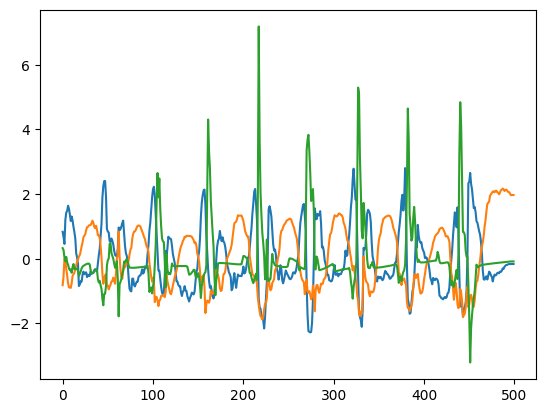

In [133]:
time_serie = complete_padded_data[0, 0, 0, 100:600, 14, :]
print(time_serie.shape, time_serie.mean(axis=0), time_serie.std(axis=0))

plt.plot((time_serie - time_serie.mean(axis=0)) / time_serie.std(axis=0))
plt.show()

In [45]:
# Standardize all data padded (?)

initial_data = complete_padded_data#[0, 0, 0, ...] # correct movement n.0 by subject n.0
plot_joint_movement(initial_data, joint=14)

# Normalize each joint indipendently
standard_data = np.copy(initial_data)

L, J, F = standard_data.shape
standard_data = standard_data.reshape((L * J, F))

scaler = preprocessing.StandardScaler()
standard_data = scaler.fit_transform(standard_data)

standard_data = standard_data.reshape((L, J, F))
plot_joint_movement(standard_data, joint=14)

IndexError: index 14 is out of bounds for axis 1 with size 10

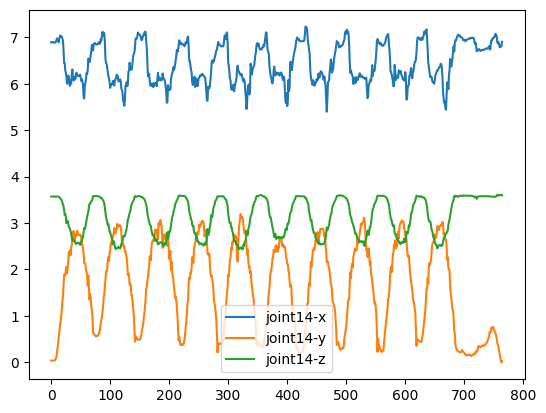

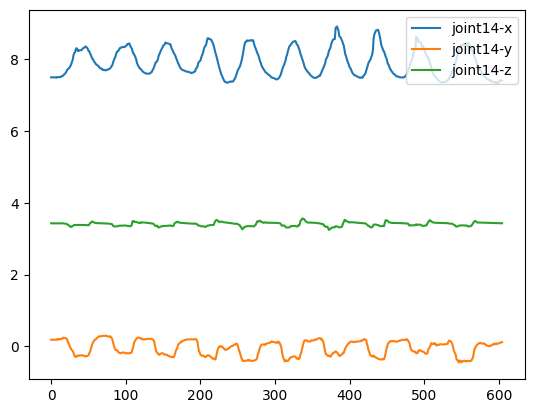

In [11]:
plot_joint_movement(correct_data[1][1], joint=14)
plot_joint_movement(correct_data[2][1], joint=14)

In [160]:
save_data_object(correct_data, 'uiprmd_correct.pkl')
save_data_object(correct_padded_data, 'uiprmd_correct_padded.pkl')
save_data_object(incorrect_data, 'uiprmd_incorrect.pkl')
save_data_object(incorrect_padded_data, 'uiprmd_incorrect_padded.pkl')